# Module 2. Local Inference

***[주의] 본 노트북은 Python 2가 아닌 Python 3에서 실행하셔야 합니다. 배치 데이터 추론 결과에 대한 다중 클래스 분류(multi-class classification) 지표(metric) 계산 시 scikit-learn 0.23.1 버전 기준의 빌트인 함수를 사용하는데, scikit-learn이 0.20 버전 이후로는 Python 2를 지원하지 않기 때문입니다.***


## Introduction

이 튜토리얼에서는 이전 노트북에서 Amazon SageMaker의 Tensorflow 1.x 사용자 스크립트로 학습한 MobileNet 모델 아티팩트 중 네트워크 구조와 가중치를 바이너리 포맷(protobuf)으로 저장한 `frozen.pb` 파일을 사용하여 로컬 상에서 추론을 수행합니다. 
이를 통해 아래의 작업들을 쉽고 빠르게 수행할 수 있습니다.

- TFLite 변환 전, 테스트셋 상에서 모델 추론 성능의 빠른 검증
- TFLite 변환 전/후 성능 편차 테스트
- 검증 데이터 및 테스트 데이터에 대해 추론 결과가 좋지 않은 경우들(예: 오분류, 미검출, 낮은 예측 score 등)에 대해 Amazon Augmented AI(이하 A2I)를 사용하여 모델 성능 개선

물론 추론 컨테이너 환경을 구축하여 SageMaker 엔드포인트 배포하여 추론을 수행할 수도 있지만, 실습의 편의성을 위해 별도의 추론 컨테이너 없이 곧바로 네트워크 구조와 모델 파라메터를 로드하여 추론을 수행하겠습니다. 


## 1. Inference Graph 구축

In [1]:
from PIL import Image
from matplotlib.pyplot import imshow
import os
import numpy as np
import glob
from os import listdir
from os.path import isfile, join
from utils import inference_utils as iu

In [2]:
with open('./img_datasets/labels.txt') as f:
    l_lines = f.readlines()
    labels = [ line.replace('\n','') for line in l_lines ]

모델은 초기화 시에만 생성하여 메모리에 로드합니다. 매번 입력 데이터에 대해 모델을 재생성하는 것은 많은 지연 시간을 초래합니다.

In [3]:
model_filepath='./model_result/inference_graph_frozen.pb'
model = iu.MobileNetInference(model_filepath, labels)

In [4]:
all_tensors = model.get_all_tensors()
print(all_tensors[-1])

Tensor("MobilenetV1/Predictions/Reshape_1:0", shape=(1, 37), dtype=float32)


In [5]:
model.get_input_node_info()

name: "input"
op: "Placeholder"
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 224
      }
      dim {
        size: 224
      }
      dim {
        size: 3
      }
    }
  }
}

## 2. 샘플 데이터 추론

앞에서 정의한 클래스의 predict 메소드를 사용하여 간단하게 이미지 파일에 대한 추론 결과를 확인할 수 있습니다.

In [6]:
test_img_path = './samples/*/*'
test_img_list = glob.glob(test_img_path)

아래 코드 셀을 여러 번 반복해 보세요 :) `CTRL+Enter` 단축키를 사용하시면 편리합니다.

./samples/Persian/Persian_78.jpg


(26,
 '26:Ragdoll',
 0.38298962,
 array([9.2050582e-02, 2.2761789e-03, 5.3920667e-04, 3.9962448e-02,
        4.5557781e-03, 1.1139183e-01, 4.8091146e-04, 6.3259911e-05,
        5.7675398e-04, 3.4486243e-04, 2.4308317e-04, 2.0955870e-04,
        3.0456334e-01, 6.7256303e-03, 1.0339462e-03, 1.4318968e-04,
        7.0839160e-04, 1.2427857e-04, 1.5261628e-02, 2.3783278e-04,
        2.3426816e-03, 1.7857288e-04, 5.4122048e-04, 1.7823067e-02,
        7.7685376e-04, 1.8151260e-03, 3.8298962e-01, 3.8601534e-04,
        8.2813128e-04, 1.1871792e-03, 1.8223511e-05, 3.1147096e-03,
        6.7511096e-04, 2.5303243e-03, 2.5097052e-05, 2.8252017e-03,
        4.5015058e-04], dtype=float32))

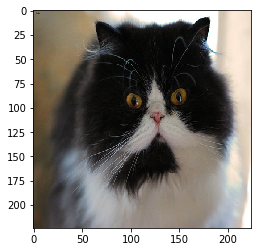

In [7]:
idx = np.random.randint(0,len(test_img_list))
test_image = test_img_list[idx]
print(test_image)
model.predict(test_image, img_size=224)

## 3. 배치 데이터 추론

여러분의 개인 랩탑/데스크탑이나 온프레미스에서 수행하는 방법과 동일하게 배치 데이터도 쉽게 추론이 가능합니다.  
본 예시에서는 테스트 데이터에 대해서 간단하게 배치 추론을 수행해 보고, 기본적인 평가 지표들인 ```Confusion Matrix```, ```AUROC(Area Under a ROC Curve)```, ```AUPRC(Area Under a Precision-Recall Curve)```를 확인해 보겠습니다.

In [8]:
!pip install scikit-learn==0.23.1

You should consider upgrading via the 'pip install --upgrade pip' command.


In [9]:
classnum_to_classname = {}
classname_to_classnum = {}
for class_name in labels:
    cls_split = class_name.split(':')
    classnum_to_classname[int(cls_split[0])] = cls_split[1]
    classname_to_classnum[cls_split[1]] = int(cls_split[0])

In [10]:
test_img_path = './samples/*/*'
test_img_list = glob.glob(test_img_path)

In [11]:
y_true_str = [img_list.split('/')[2] for img_list in test_img_list]
y_true = np.array([classname_to_classnum[s] for s in y_true_str])

아래 코드 셀에서 테스트 데이터셋에 대한 추론을 아래 절차로 수행합니다. 

- 정답값에 대한 One-hot encoding 변환 수행
- 배치 추론을 수행 후, 예측 score 및 결과(class) 리턴
- 예측 결과에 대한 One-hot encoding 변환 수행

In [12]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(categories='auto', sparse=False)
num_classes = len(labels)

y_true_ohe = enc.fit_transform(y_true.reshape(-1, 1))
y_score, y_pred = iu.get_test_scores(model, test_img_list, '', num_classes)
y_pred_ohe = enc.transform(y_pred.reshape(-1,1))

y_pred_str = [classnum_to_classname[int(score)] for score in y_pred]

In [13]:
y_pred[:10], y_pred_str[:10]

(array([ 9,  9,  9,  9,  9,  9, 32, 11,  4,  9]),
 ['Sphynx',
  'Sphynx',
  'Sphynx',
  'Sphynx',
  'Sphynx',
  'Sphynx',
  'Russian_Blue',
  'staffordshire_bull_terrier',
  'British_Shorthair',
  'Sphynx'])

다중 클래스의 plotting에 필요한 컬러 테이블을 랜덤하게 생성합니다.

In [14]:
import random
color_table = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(num_classes)]

### Confusion Matrix

                               precision    recall  f1-score   support

              0:japanese_chin       0.86      0.60      0.71        10
          1:yorkshire_terrier       1.00      0.60      0.75        10
                     2:beagle       0.62      0.50      0.56        10
                 3:Maine_Coon       0.75      0.60      0.67        10
          4:British_Shorthair       0.56      1.00      0.71        10
                     5:Birman       0.62      0.80      0.70        10
     6:english_cocker_spaniel       0.50      0.20      0.29        10
                        7:pug       1.00      0.60      0.75        10
                      8:boxer       0.57      0.40      0.47        10
                     9:Sphynx       0.88      0.70      0.78        10
        10:miniature_pinscher       0.60      0.30      0.40        10
11:staffordshire_bull_terrier       0.33      0.70      0.45        10
                   12:Persian       0.75      0.60      0.67        10
     

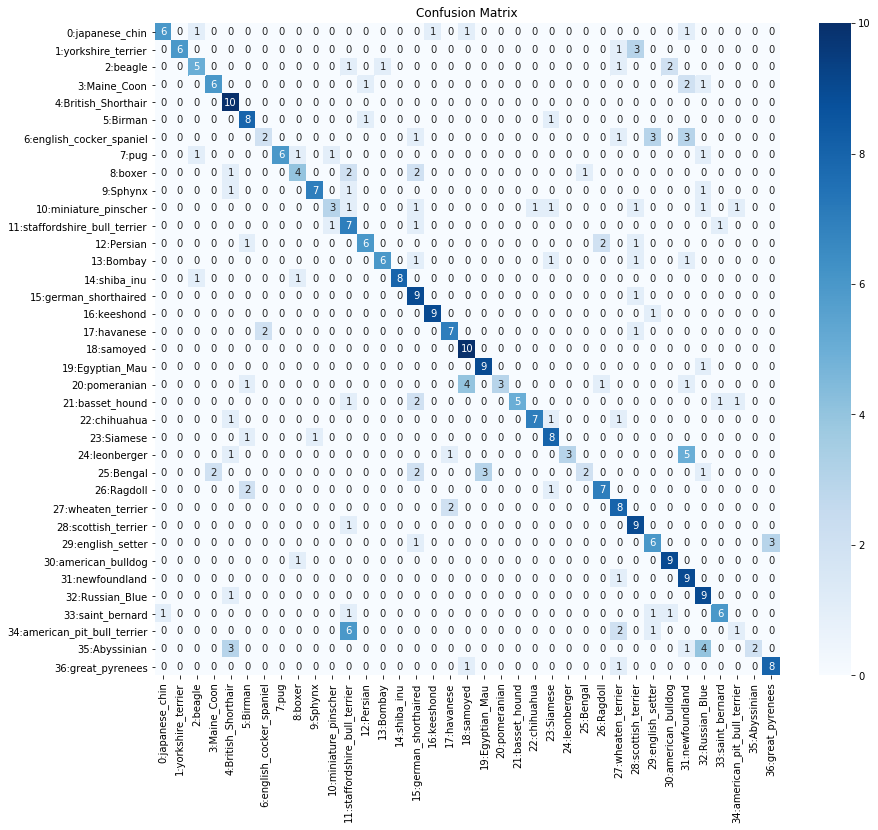

In [15]:
iu.plot_conf_mtx_multiclass(y_true, y_pred, labels)

### ROC Curve

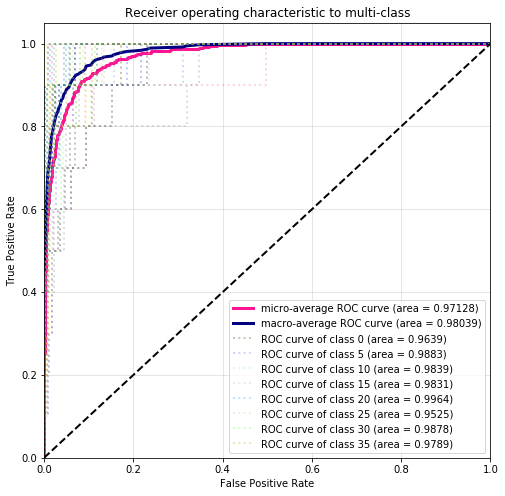

In [16]:
iu.plot_roc_curve_multiclass(y_true_ohe, y_score, num_classes, color_table)

### Precision-Recall Curve

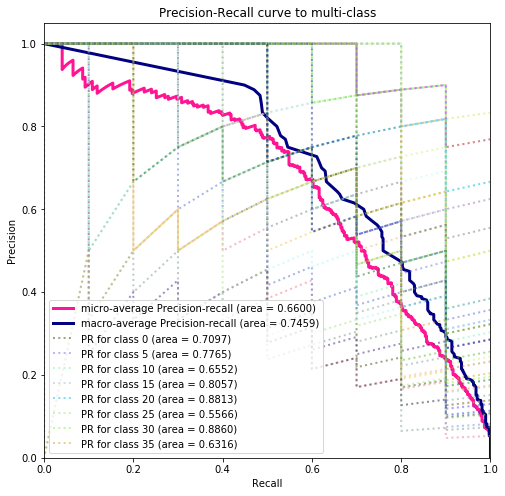

In [17]:
iu.plot_pr_curve_multiclass(y_true_ohe, y_score, num_classes, color_table)